In [1]:
import yaml
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import shapely.affinity as aff
import shapely.geometry as geo

from electronfactors import (
    shapely_ellipse, _CustomBasinhopping,
    display_shapely, display_stored_cutout,
    print_ellipse,
    fit_give,
    create_green_cm
)

In [2]:
from matplotlib import rc
rc('font',**{'family':'serif',
             'size':'20'})
# rc('text', usetex=True)

rc('legend', fontsize=16, scatterpoints=1)

In [3]:
green_cm = create_green_cm()

In [4]:
def to_eqPonA(width, length):
    ratio = width/length
    eqPonA = 2*(3*(ratio+1) - np.sqrt((3*ratio+1)*(ratio+3))) / width
    
    return eqPonA

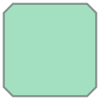

In [5]:
def shapely_aperture(aperture_size):
    bevel = 1.0
    size_at_100 = aperture_size
    pos = size_at_100/2 - bevel
    base_square = geo.Polygon([(-pos, -pos),
                          (pos, -pos),
                          (pos, pos),
                          (-pos, pos)])

    aperture = base_square.buffer(bevel, join_style=3)    
    return aperture

shapely_aperture(10)

In [6]:
def make_to_minimise(width, edge_buffer, aperture_size):
    aperture = shapely_aperture(aperture_size) 
    aperture_erroded = aperture.buffer(-edge_buffer)
    
    def to_minimise(optimiser_input):
        ellipse_input = [
            0, 0, width,
            optimiser_input[0], optimiser_input[1]]
        ellipse = shapely_ellipse(ellipse_input)
        return (100 * ellipse.difference(aperture_erroded).area + 
                aperture_erroded.difference(ellipse).area)
    return to_minimise

def ellipse_in_aperture(width, edge_buffer, aperture_size):

    initial = np.array([aperture_size, 45])
    step_noise = np.array([aperture_size, 30])

    optimiser = _CustomBasinhopping(
        to_minimise=make_to_minimise(width, edge_buffer, aperture_size),
        initial=initial,
        step_noise=step_noise,
        n=3,
        confidence=0.01
    )
    
    length = optimiser.result[0]
    angle = optimiser.result[1]
    
    ellipse_input = [0, 0, width, length, angle]
    ellipse = shapely_ellipse(ellipse_input)

    aperture = shapely_aperture(aperture_size)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    display_shapely(aperture, ax=ax, random_colours=False)
    display_shapely(ellipse, ax=ax, random_colours=False)    
    plt.show()
    
    return length

In [7]:
def batch_ellipse_in_aperture(width_list, errosion, aperture_size):    
    length_list = [
        ellipse_in_aperture(width, errosion, aperture_size) 
        for width in width_list]    
        
    return np.abs(length_list)

In [8]:
edge_buffer = 0.125
width = dict()
length = dict()
eqPonA = dict()

long_ellipse_width = dict()
long_ellipse_length = dict()

circles = dict()

thin_ellipses_width = dict()
thin_ellipses_length = dict()

short_ellipses_width = dict()
short_ellipses_length = dict()

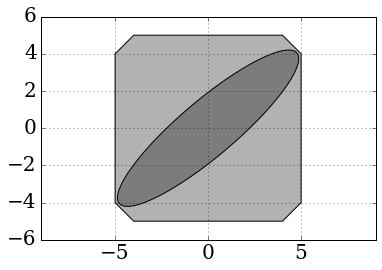

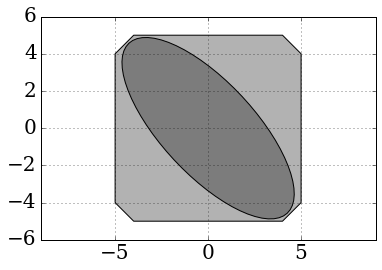

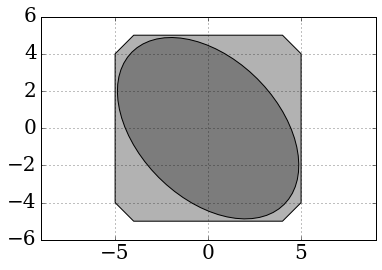

In [9]:
aperture_size = 10
long_ellipse_width[aperture_size] = [3, 5, 7.5]

long_ellipse_length[aperture_size] = batch_ellipse_in_aperture(
    long_ellipse_width[aperture_size], 
    edge_buffer, aperture_size)

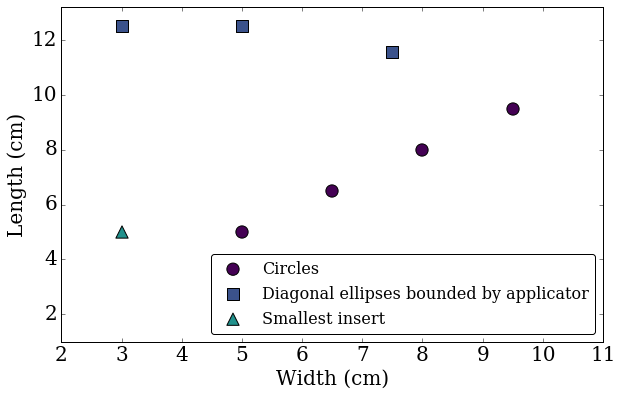

In [10]:
plt.figure(figsize=(6 * 1.618, 6))

circles[aperture_size] = np.array([5, 6.5, 8, 9.5])
plt.scatter(
    circles[aperture_size],
    circles[aperture_size], 
    c=[0.26700401, 0.00487433, 0.32941519], s=150, 
    label='Circles')

aperture_size = 10
plt.scatter(
    long_ellipse_width[aperture_size], 
    long_ellipse_length[aperture_size], s=150, c=green_cm(0.25),
    label='Diagonal ellipses bounded by applicator', marker='s')

thin_ellipses_width[aperture_size] = [3]
thin_ellipses_length[aperture_size] = [5]
plt.scatter(
    thin_ellipses_width[aperture_size], 
    thin_ellipses_length[aperture_size], c=green_cm(0.5), s=150, 
    label='Smallest insert', marker='^')

plt.xlabel("Width (cm)")
plt.ylabel("Length (cm)")

plt.xlim([2,11])
plt.ylim([1,13.2])

plt.legend(fancybox=True, loc='lower right')

[ 5.   6.5  8.   9.5  3.   5.   7.5  3. ]
[ 0.8         0.61538462  0.5         0.42105263  0.90603688  0.58610954
  0.44446539  1.08339895]


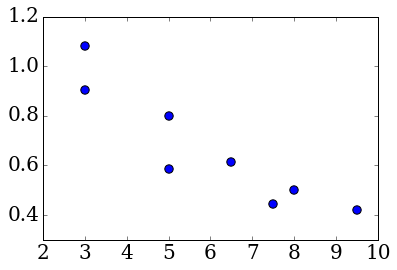

In [11]:
width[aperture_size] = np.concatenate([
    circles[aperture_size], 
    long_ellipse_width[aperture_size],
    thin_ellipses_width[aperture_size]])

print(width[aperture_size])

length[aperture_size] = np.concatenate([
    circles[aperture_size], 
    long_ellipse_length[aperture_size], 
    thin_ellipses_length[aperture_size]])

eqPonA[aperture_size] = to_eqPonA(
    width[aperture_size], length[aperture_size])

print(eqPonA[aperture_size])

plt.scatter(width[aperture_size], eqPonA[aperture_size], s=70)

In [12]:
x = np.arange(2, 10, 0.1)
y = np.arange(0.3, 1.2, 0.02)

xx, yy = np.meshgrid(x, y)

factor_test = np.ones(np.shape(width[aperture_size]))
give = fit_give(xx, yy, width[aperture_size], eqPonA[aperture_size], factor_test, kx=2, ky=1)

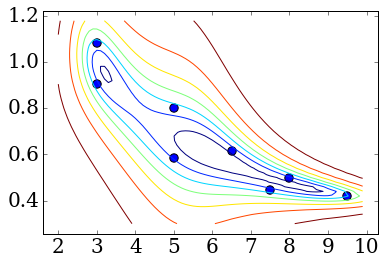

In [13]:
plt.scatter(width[aperture_size], eqPonA[aperture_size], s=70)
plt.contour(xx, yy, give)

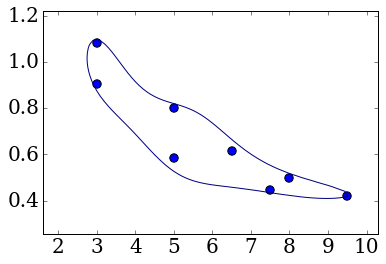

In [14]:
plt.scatter(width[aperture_size], eqPonA[aperture_size], s=70)
plt.contour(xx, yy, give, levels=[0.5])

In [15]:
x = np.arange(2, 10, 0.1)
y = np.arange(2, 14, 0.1)

mesh_width, mesh_length = np.meshgrid(x, y)

mesh_eqPonA = to_eqPonA(mesh_width, mesh_length)

give_translated = fit_give(
    mesh_width, mesh_eqPonA, width[aperture_size], eqPonA[aperture_size], factor_test, kx=2, ky=1)

In [16]:
green_cm(0.1)

(0.28262296999999997, 0.14092556000000001, 0.45751725999999998, 1.0)

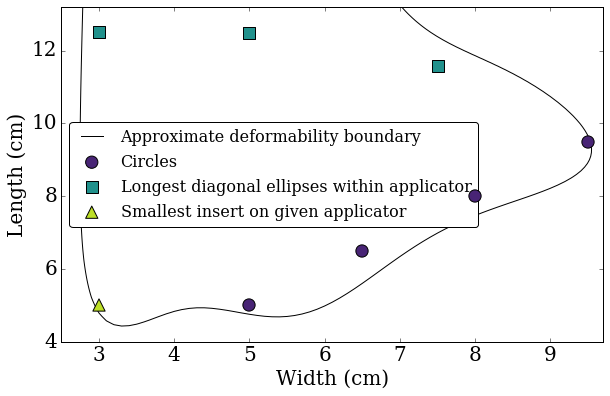

In [17]:
plt.figure(figsize=(6 * 1.618, 6))

plt.scatter(
    circles[aperture_size],
    circles[aperture_size], 
    c=[0.28262296999999997, 0.14092556000000001, 0.45751725999999998], s=150, 
    label=r'Circles', zorder=20)

aperture_size = 10
plt.scatter(
    long_ellipse_width[aperture_size], 
    long_ellipse_length[aperture_size], s=150, c=green_cm(0.5),
    label=r'Longest diagonal ellipses within applicator', marker='s')

plt.scatter(
    thin_ellipses_width[aperture_size], 
    thin_ellipses_length[aperture_size], c=green_cm(0.9), s=150, 
    label=r'Smallest insert on given applicator', marker='^', zorder=20)

plt.contour(mesh_width, mesh_length, give_translated, levels=[0.5], colors='k')
plt.plot(3, 0.4, 'k-', label=r'Approximate deformability boundary')

plt.xlabel(r'Width (cm)')
plt.ylabel(r'Length (cm)')

plt.xlim([2.5, 9.7])
plt.ylim([4, 13.2])

plt.legend(fancybox=True, loc='center left')

# plt.savefig('figures/where_to_measure.png', bbox_inches='tight', dpi=300)
# plt.savefig('figures/where_to_measure.eps', bbox_inches='tight')